<a href="https://colab.research.google.com/github/JamesAllingham/DFL-WGAN/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Simple Tensorflow GAN implementation


###Imports

In [0]:
import tensorflow as tf
import keras # use keras rather than tf.keras to avoid some nasty warning messages during training
# these are some of the layers that might be useful for defining our GAN
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Conv2DTranspose, Conv2D, Input, Activation, UpSampling2D, Dropout
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Load Data

Lets load the FashionMNIST dataset and have a quick look:

In [0]:
fashionMNIST = keras.datasets.fashion_mnist
(train_images, train_labels), _ = fashionMNIST.load_data()
fashionMNIST_labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Boot"]

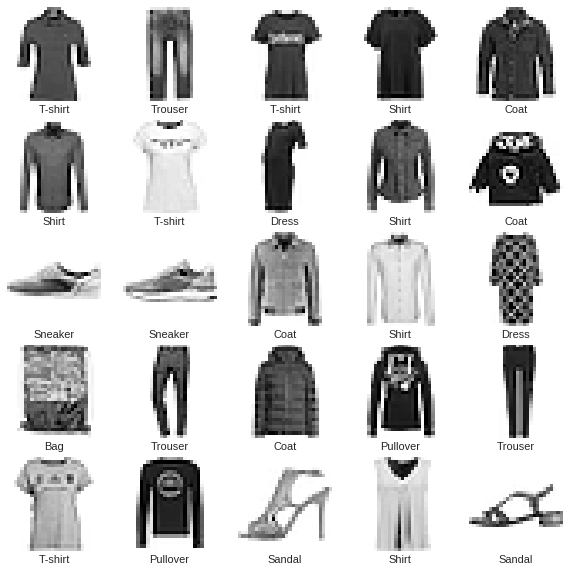

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  img_index = np.random.randint(0, 40000)
  plt.imshow(train_images[img_index])
  plt.xlabel(fashionMNIST_labels[train_labels[img_index]])

In [0]:
# rescale images (seems to help with training - try to remove this next line)
train_images = train_images / 255
# reshape the images so that Keras is happy
train_images = np.expand_dims(train_images, axis=3)

### Define a Discriminator and a Generator

The *discriminator* should take a 28x28x1 array as its input and return a scalar between 0 and 1. This scalar will be interpred as the probability that the image is real.

The *generator* should take a vector and return a 28x28x1 array. The size of the vector is the *latent dimmension* and is a parameter that can be tuned. There is also a choice here: generate images with pixels between 0 and 1, 0 and 255, or even -1 and 1.

The architectures for the generator and discriminator can also be tuned in a number of ways. However, you might want to draw inspiration from the [DCGAN architecture by _Radford et al._](https://arxiv.org/abs/1511.06434). Here are some tips from their [git repo](https://github.com/Newmu/dcgan_code):


* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
* Use batchnorm in both the generator and the discriminator
* Remove fully connected hidden layers for deeper architectures. Just use average pooling at the end.
* Use ReLU activation in generator for all layers except for the output, which uses Tanh.
* Use LeakyReLU activation in the discriminator for all layers.


In [0]:
img_shape = (28, 28, 1)

# define model hyper-params - play with these!
latent_size = 100
gen_lr = 1e-3
dis_lr = 2e-4

In [0]:
discriminator = keras.Sequential([
#     Conv2D(64, 4, 2, input_shape=img_shape),
#     LeakyReLU(alpha=0.2),
#     Conv2D(128, 4, 2),
#     LeakyReLU(alpha=0.2),
#     BatchNormalization(),
#     Flatten(),
#     Dense(1024),
#     LeakyReLU(alpha=0.2),
#     BatchNormalization(),
#     Dense(1)
    
#       Flatten(input_shape=img_shape),
#       Dense(512),
#       LeakyReLU(alpha=0.2),
#       Dense(256),
#       LeakyReLU(alpha=0.2),
#       Dense(1, activation='sigmoid')
    
    Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"),
    LeakyReLU(alpha=0.2),
    Dropout(0.25),
    Conv2D(64, kernel_size=3, strides=2, padding="same"),
    BatchNormalization(momentum=0.8),
    LeakyReLU(alpha=0.2),
    Dropout(0.25),
    Conv2D(128, kernel_size=3, strides=2, padding="same"),
    BatchNormalization(momentum=0.8),
    LeakyReLU(alpha=0.2),
    Dropout(0.25),
    Conv2D(256, kernel_size=3, strides=1, padding="same"),
    BatchNormalization(momentum=0.8),
    LeakyReLU(alpha=0.2),
    Dropout(0.25),
    Flatten(),
    Dense(1, activation='sigmoid'),
])

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
__________

In [0]:
generator = keras.Sequential([
#     Dense(1024, input_dim=latent_size),
#     LeakyReLU(alpha=0.2),
#     BatchNormalization(),
#     Dense(7 * 7 * 128),
#     LeakyReLU(alpha=0.2),
#     BatchNormalization(),
#     Reshape([7, 7, 128]),
#     Conv2DTranspose(64, 4, strides=2, padding='same'),
#     LeakyReLU(alpha=0.2),
#     BatchNormalization(),
#     Conv2DTranspose(1, 4, strides=2, activation='sigmoid', padding='same')
    
#     Dense(256, input_dim=latent_size),
#     LeakyReLU(alpha=0.2),
#     BatchNormalization(momentum=0.8),
#     Dense(512),
#     LeakyReLU(alpha=0.2),
#     BatchNormalization(momentum=0.8),
#     Dense(1024),
#     LeakyReLU(alpha=0.2),
#     BatchNormalization(momentum=0.8),
#     Dense(np.prod(img_shape), activation='sigmoid'),
#     Reshape(img_shape)
    
    Dense(7 * 7 * 128, activation="relu", input_dim=latent_size),
    Reshape([7, 7, 128]),
    UpSampling2D(),
    Conv2D(128, kernel_size=3, padding="same"),
    BatchNormalization(momentum=0.8),
    Activation("relu"),
    UpSampling2D(),
    Conv2D(64, kernel_size=3, padding="same"),
    BatchNormalization(momentum=0.8),
    Activation("relu"),
    Conv2D(1, kernel_size=3, padding="same"),
    Activation("tanh")
])

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 128)       0         
__________

The following code snippit creates a combined model that will allow us to train the generator based on the output of the discriminator. Note that in the combined model the disciminator is not trained.

In [0]:
discriminator.trainable = False
combined = keras.Sequential([
    generator,
    discriminator
])

combined.compile(loss='binary_crossentropy', optimizer=Adam(gen_lr, 0.5))

combined.summary()

discriminator.trainable = True
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(dis_lr, 0.5), metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28, 1)         856193    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 393729    
Total params: 1,249,922
Trainable params: 855,809
Non-trainable params: 394,113
_________________________________________________________________


### Train the GAN

Depending on your architectures of your generator and discriminator you might need to train for 1000 to 10000 rounds before you see any reasonable images being generated.

In [0]:
# define training hyper-params
rounds = 3000
batch_size = 128

# create labels
real_labels = np.ones((batch_size, 1))
gen_labels = np.zeros((batch_size, 1))

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 	 D loss: 1.098215 	 D acc.: 36.33% 	 G loss: 0.654051


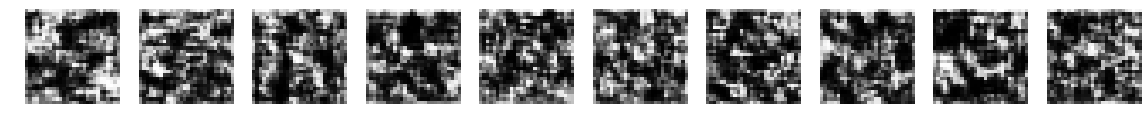

100 	 D loss: 0.790654 	 D acc.: 49.61% 	 G loss: 1.110283


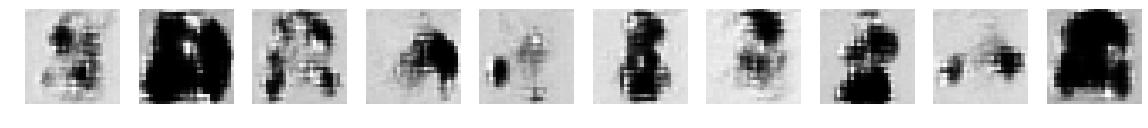

200 	 D loss: 0.786840 	 D acc.: 53.91% 	 G loss: 1.242790


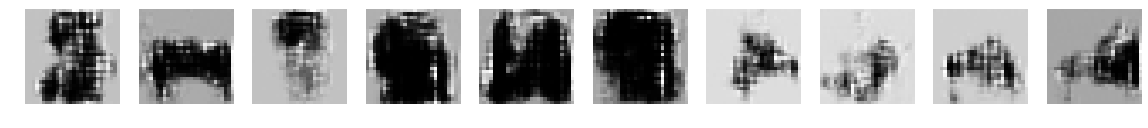

300 	 D loss: 0.769293 	 D acc.: 49.22% 	 G loss: 0.839402


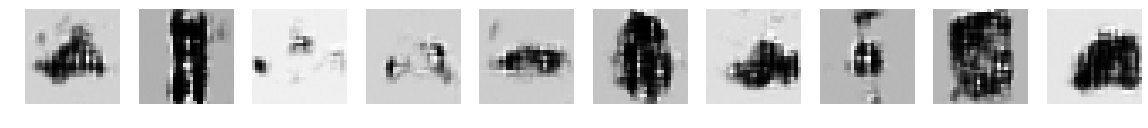

400 	 D loss: 0.623730 	 D acc.: 64.84% 	 G loss: 1.108121


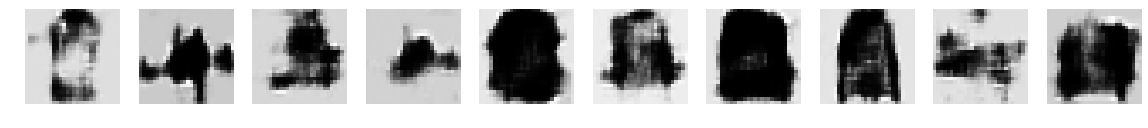

500 	 D loss: 0.612198 	 D acc.: 63.67% 	 G loss: 1.132179


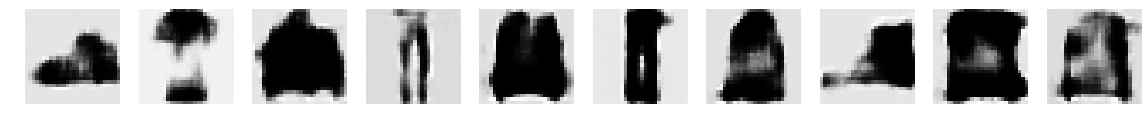

600 	 D loss: 0.729649 	 D acc.: 51.56% 	 G loss: 0.947022


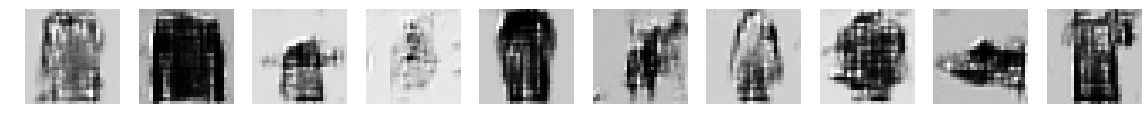

700 	 D loss: 0.757668 	 D acc.: 52.34% 	 G loss: 0.980238


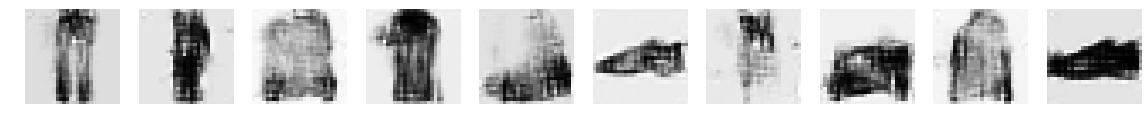

800 	 D loss: 0.731927 	 D acc.: 57.42% 	 G loss: 0.951811


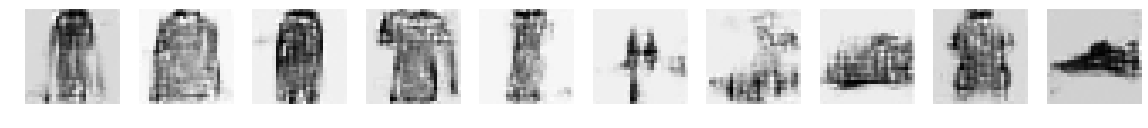

900 	 D loss: 0.744315 	 D acc.: 52.73% 	 G loss: 0.975270


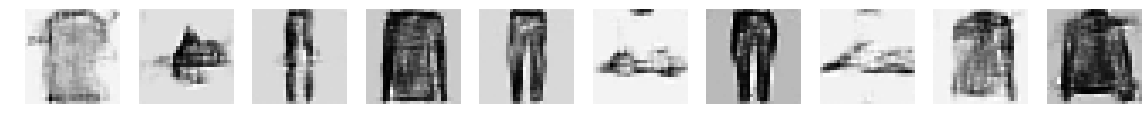

1000 	 D loss: 0.753907 	 D acc.: 48.44% 	 G loss: 0.999249


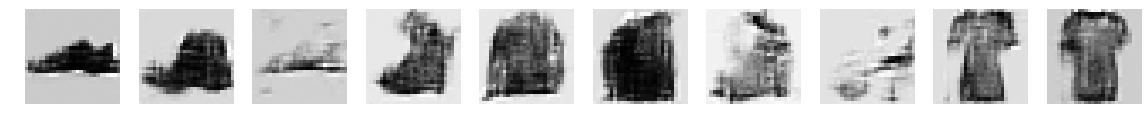

1100 	 D loss: 0.725256 	 D acc.: 54.30% 	 G loss: 0.852071


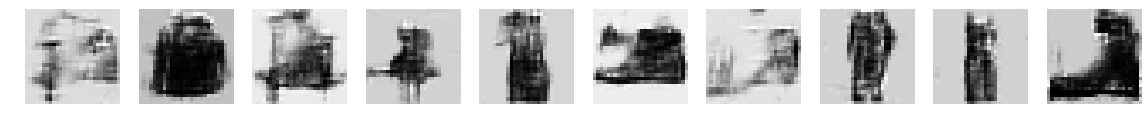

1200 	 D loss: 0.703498 	 D acc.: 51.17% 	 G loss: 0.856782


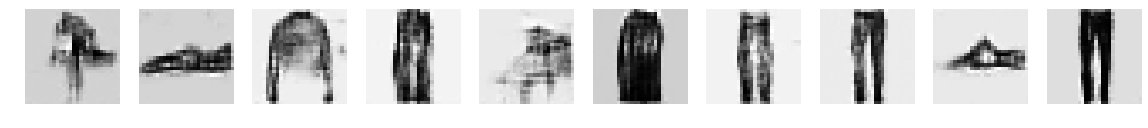

1300 	 D loss: 0.697001 	 D acc.: 56.25% 	 G loss: 0.975389


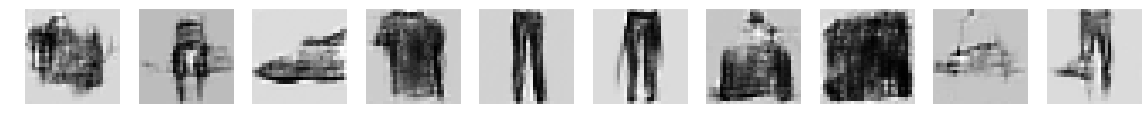

1400 	 D loss: 0.708045 	 D acc.: 57.03% 	 G loss: 0.808295


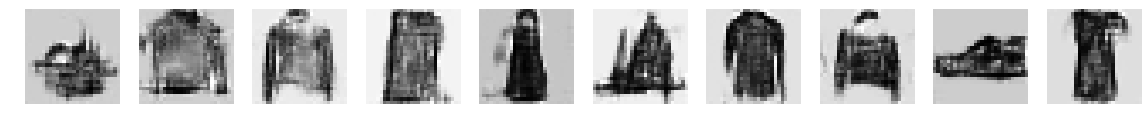

1500 	 D loss: 0.738770 	 D acc.: 48.05% 	 G loss: 0.879471


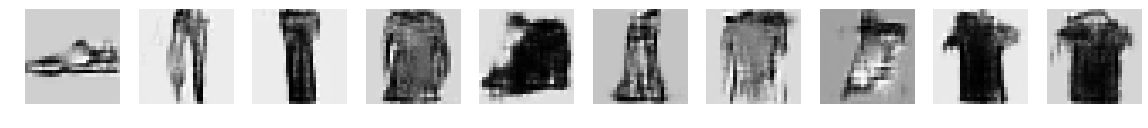

1600 	 D loss: 0.688006 	 D acc.: 55.86% 	 G loss: 0.964954


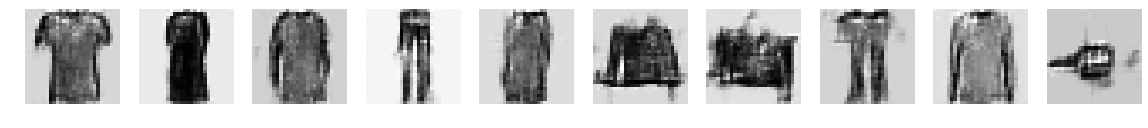

1700 	 D loss: 0.710886 	 D acc.: 50.39% 	 G loss: 0.822201


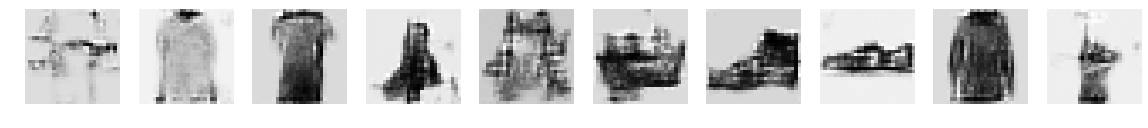

1800 	 D loss: 0.714691 	 D acc.: 51.56% 	 G loss: 0.863200


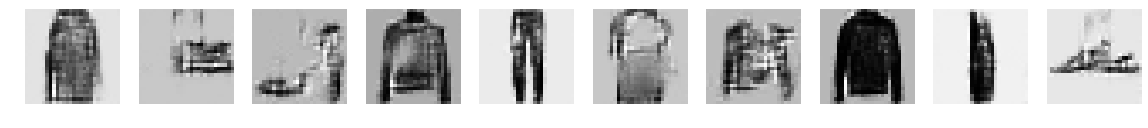

1900 	 D loss: 0.723822 	 D acc.: 50.00% 	 G loss: 0.808793


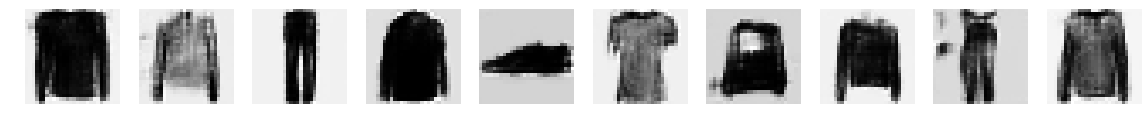

2000 	 D loss: 0.684633 	 D acc.: 57.42% 	 G loss: 0.849407


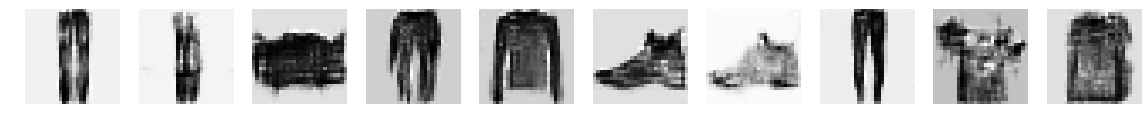

2100 	 D loss: 0.731616 	 D acc.: 50.78% 	 G loss: 0.838944


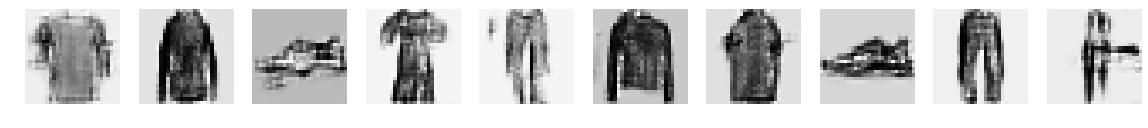

2200 	 D loss: 0.735656 	 D acc.: 47.27% 	 G loss: 0.827739


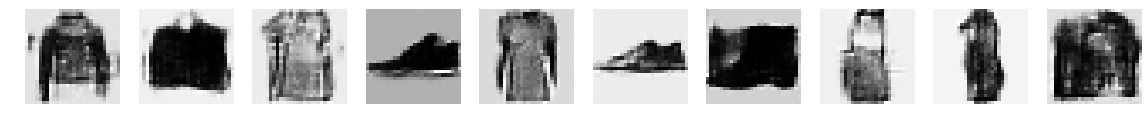

2300 	 D loss: 0.723595 	 D acc.: 48.05% 	 G loss: 0.856471


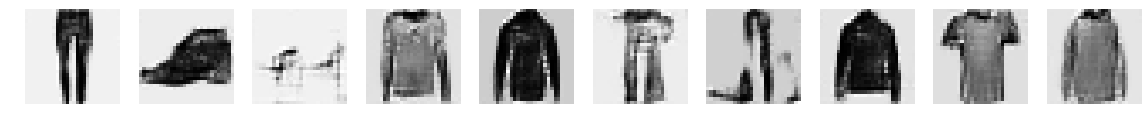

2400 	 D loss: 0.689706 	 D acc.: 51.56% 	 G loss: 0.889532


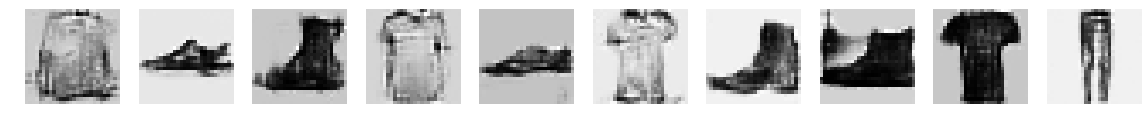

2500 	 D loss: 0.683957 	 D acc.: 53.12% 	 G loss: 0.865923


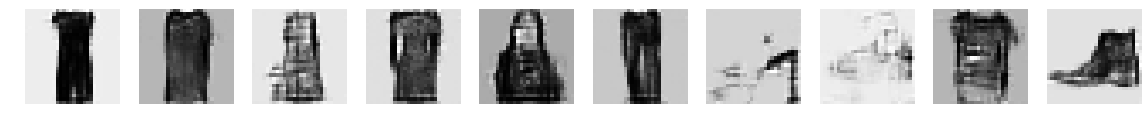

2600 	 D loss: 0.713323 	 D acc.: 51.56% 	 G loss: 0.872841


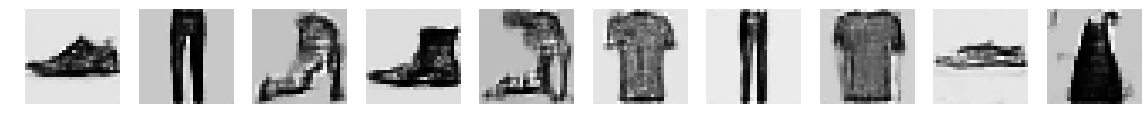

2700 	 D loss: 0.687872 	 D acc.: 52.34% 	 G loss: 0.833032


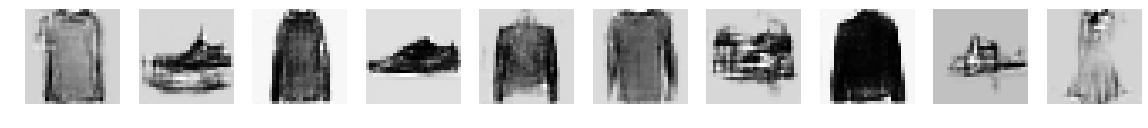

2800 	 D loss: 0.677463 	 D acc.: 60.55% 	 G loss: 0.892761


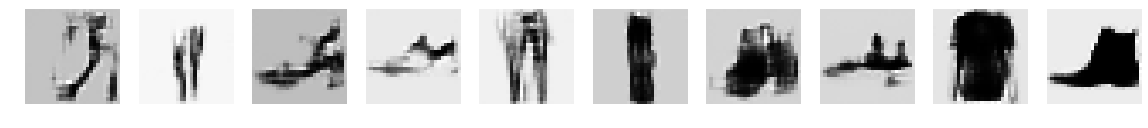

2900 	 D loss: 0.682057 	 D acc.: 57.81% 	 G loss: 0.899161


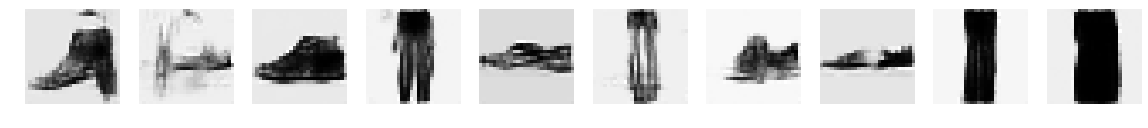

3000 	 D loss: 0.708704 	 D acc.: 53.12% 	 G loss: 0.898719


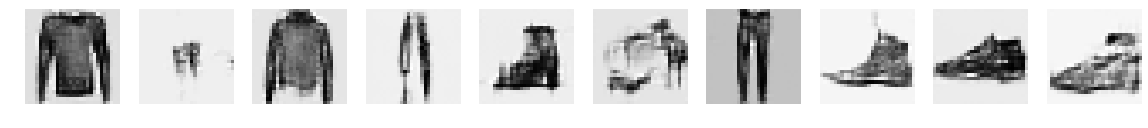

In [0]:
for r in range(rounds + 1):
  
  ## train discrimiator 
  
  # get a random batch of real examples and generate a batch of fake examples
  idx = np.random.randint(0, train_images.shape[0], batch_size)
  real_imgs = train_images[idx]
  
  noise = np.random.normal(0, 1, (batch_size, latent_size))
  gen_imgs = generator.predict(noise)
  
  gan_d_loss_real = discriminator.train_on_batch(real_imgs, real_labels) 
  gan_d_loss_gen = discriminator.train_on_batch(gen_imgs, gen_labels)
  gan_d_loss = 0.5 * np.add(gan_d_loss_real, gan_d_loss_gen)
  
  ## train generator
  
  # generate random images and minimize the disciminators belief that these are fake
  noise = np.random.normal(0, 1, (batch_size, latent_size))

  gan_g_loss = combined.train_on_batch(noise, real_labels) 
  
  if r % 100 == 0:
    print ("%d \t D loss: %f \t D acc.: %.2f%% \t G loss: %f" % (r, gan_d_loss[0], 100*gan_d_loss[1], gan_g_loss))
    
    noise = np.random.normal(0, 1, (10, latent_size))
    gen_imgs = generator.predict(noise)
      
    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    for i in range(10):
      axs.flat[i].imshow(gen_imgs[i].squeeze())
      axs.flat[i].axis('off');
    display(fig)
    plt.close(fig)
  